# Autocodificadores Variacionais

## 1. Arquitetura do Modelo

O presente notebook faz o processamento do conjunto de dados "Fashion Mnist" com a técnica de autoencoders variacionais (VAE) para ser capaz de gerar imagens sintéticas baseadas nos exemplos oferecidos pelo modelo.

```                      
                           camada
                       +-> densa --+
 camada de      camada |   2       |         espaço     camada    camada 
   entrada -->   densa +          lambda* -> latente -> densa  -> de saída 
       784         512 |   camada  |         2          512       784
                       +-> densa --+
                           2

 * o lambda é uma função de renormalização                                     
```

Exceto pela renormalização é um autoencoder padrão. Um vetor de duas dimensões é muito pequeno para gravar dados da image, desta forma é evidente que este vetor serve meio que como um identificador da imagem que está armazenada no decoder. Como temos 9 "sementes" é esperado que até 9 pontos correspondam as imagens puras e devido ao mecanismo variacional, 

## 2. Resultados observados

O vetor de dois números é um espaço bidimensional que acabou ficando mais ou menos da seguinte forma:
```
+--------------------------------------------+
|[agasalho]                        [camiseta]|
|                                            |
|                                            |
|     [bolsa]                      [vestido] |
|                                            |
|                                            |
|                                  [calça]   |
|[salto alto]                                |
|                                            |
|[bota]         [tenis]            [chinelo] |
+--------------------------------------------+
```
Entre cada objeto se formaram misturas dos objetos. 

Algumas misturas ficaram bem ruins, especialmente na fronteira ao redor das bolsas e entre os calçados e o resto. 

Mas algumas combinações ficaram bem interessantes:
* As transições entre agasalhos, camisetas vestidos estão bem aproveitáveis;
* As transições entre botas, tenis e chinelo também ficaram boas;
* As transições entre calças e vestidos geraram alguns macacões que é algo que não encontramos no conjunto de dados original.

# Considerações Finais

É importante ressaltar que o espaço latente tem apenas dois números para descrever cada imagem. Assim é evidente que as estruturas das imagens estão armazenadas nos neurônios do decodificador. A impressão que dá é que a rede gravou uma versão genérica de cada uma das 10 categorias e as associou a um ponto específico deste espaço 2d e as combinações são feitas por proximidade. 

Em tese, isto aconteceria também com um autoencoder padrão, mas não haveria qualquer garantia de que a proximidade teria qualquer significado. 

## Referências:
* ROCAA, J.; 2019; Understanding Variational Autoencoders (VAEs); In: Towards data Science; Sep, 23; Disponível em: https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73; Acesso em: 30-09-2021; Obs: Boa visão da teoria.

# APENDICE 1 - Implementação

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import warnings
import scipy
warnings.filterwarnings('ignore')

import tensorflow
from tensorflow.keras import backend as K

tensorflow.config.experimental.list_physical_devices('GPU')



[]

#### Carrega o conjunto de dados

4431872/4422102 [==============================] - 0s 0us/step
Carregado o conjunto de dados Fashion Mnist...
Exemplos:


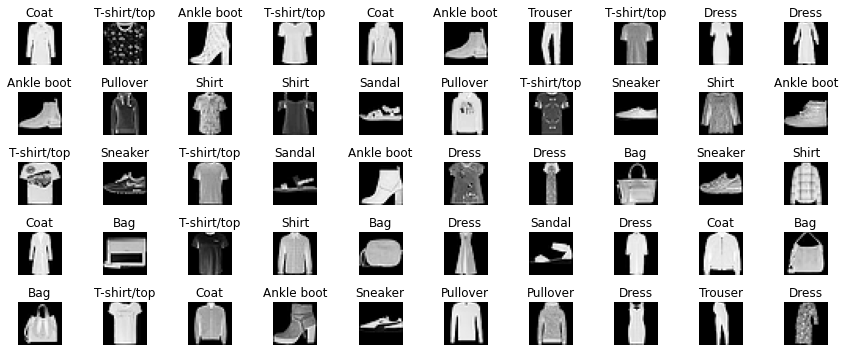

Conjunto de treinamento: X=(60000, 784), y=(60000,)
Conjunto de testes: X=(10000, 784), y=(10000,)


In [2]:
#@title
def bloco():

  global X_train, Y_train, X_test, Y_test, Y_names

  Y_names = [
      'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
      'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
      ]

  (X_train, Y_train), (X_test, Y_test) = tensorflow.keras.datasets.fashion_mnist.load_data()
  
  X_train = X_train.astype('float32') / 255
  X_test = X_test.astype('float32') / 255

  

  print('Carregado o conjunto de dados Fashion Mnist...')
  print('Exemplos:')

  w = 10
  h = 5
  fig, ax = plt.subplots(h,w, figsize=(12,5))  
  for x in range(w):
    for y in range(h):
      i = np.random.randint(0, len(Y_train))
      ax[y][x].imshow(X_train[i], cmap='gray')
      ax[y][x].set_title(Y_names[Y_train[i]])
      ax[y][x].axis('off')

  plt.tight_layout()
  plt.show()

  global image_width, image_height, image_layers

  image_width = X_train.shape[1]
  image_height = X_train.shape[2]
  if( len(X_train.shape) == 3 ):
    X_train = X_train.reshape((-1,image_width,image_height,1))
    X_test = X_test.reshape((-1,image_width,image_height,1))

  image_layers = X_train.shape[3]

  X_train = X_train.reshape((-1,image_width*image_height*image_layers))
  X_test = X_test.reshape((-1,image_width*image_height*image_layers))
  Y_train = Y_train.flatten()
  Y_test = Y_test.flatten()

  print('Conjunto de treinamento: X=%s, y=%s' % (X_train.shape, Y_train.shape))
  print('Conjunto de testes: X=%s, y=%s' % (X_test.shape, Y_test.shape))

bloco()

# Construção do Modelo

In [49]:
def bloco():

  global model, encoder, decoder, encoder_layer_out

  espaco_latente_dimensoes = 2

  # encoder: modelo padrão
  encoder_layer_input = tensorflow.keras.layers.Input(
      shape=( image_width * image_height * image_layers ), 
      name='encoder_layer_input'
    )
  encoder_layer_x = tensorflow.keras.layers.Dense(
      128, # quantidade de neurônios
      activation='sigmoid',
      name='encoder_layer_x'
    )(encoder_layer_input)
  encoder_layer_x2 = tensorflow.keras.layers.Dense(
      128, # quantidade de neurônios
      activation='sigmoid',
      name='encoder_layer_x2'
    )(encoder_layer_x)
  encoder_layer_out = tensorflow.keras.layers.Dense(
      espaco_latente_dimensoes, # quantidade de neurônios
      activation='sigmoid',
      name='encoder_layer_out'
    )(encoder_layer_x2)

  # instancia o modelo do encoder
  encoder = tensorflow.keras.Model(encoder_layer_input, encoder_layer_out, name='encoder')
  encoder.summary()

  # constrói o modelo do decoder
  decoder_layer_input = tensorflow.keras.layers.Input(
      shape=(espaco_latente_dimensoes), 
      name='decoder_layer_input'
    )  
  decoder_layer_x = tensorflow.keras.layers.Dense(
      128, # quantidade de neurônios
      activation='sigmoid',
      name="decoder_layer_x"
    )(decoder_layer_input)
  decoder_layer_x2 = tensorflow.keras.layers.Dense(
      128, # quantidade de neurônios
      activation='sigmoid',
      name="decoder_layer_x2"
    )(decoder_layer_x)
  decoder_layer_output = tensorflow.keras.layers.Dense(
      image_width*image_height*image_layers, # quantidade de neurônios
      activation='sigmoid',
      name="decoder_layer_output"
    )(decoder_layer_x2)

  # instancia o modelo do decoder
  decoder = tensorflow.keras.Model(decoder_layer_input, decoder_layer_output, name='decoder')
  decoder.summary()

  # instancia o modelo VAE

  encoded = encoder(encoder_layer_input)
  decoded = decoder(encoded)


  model = tensorflow.keras.Model(encoder_layer_input, decoded, name='vae_mlp')

  model.summary()
  model.compile(
      optimizer='sgd', 
      loss='categorical_crossentropy', 
      metrics=['acc']
    )


bloco()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_layer_input (InputLa [(None, 784)]             0         
_________________________________________________________________
encoder_layer_x (Dense)      (None, 128)               100480    
_________________________________________________________________
encoder_layer_x2 (Dense)     (None, 128)               16512     
_________________________________________________________________
encoder_layer_out (Dense)    (None, 2)                 258       
Total params: 117,250
Trainable params: 117,250
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_layer_input (InputLa [(None, 2)]               0         
____________________________________

In [ ]:
# treina o autoencoder
model.fit(
    X_train, X_train,
    epochs=50,
    batch_size=20,
    validation_data=(X_test, X_test)
  )

Epoch 1/50
3000/3000 [==============================] - 12s 4ms/step - loss: 74936.2578 - acc: 0.0014 - val_loss: 149649.8125 - val_acc: 0.0020
Epoch 2/50
3000/3000 [==============================] - 11s 4ms/step - loss: 222965.4375 - acc: 0.0014 - val_loss: 298451.8125 - val_acc: 0.0020
Epoch 3/50
3000/3000 [==============================] - 11s 4ms/step - loss: 370995.1875 - acc: 0.0015 - val_loss: 447256.0625 - val_acc: 6.0000e-04
Epoch 4/50
1224/3000 [===========>..................] - ETA: 5s - loss: 474742.6250 - acc: 9.8039e-04

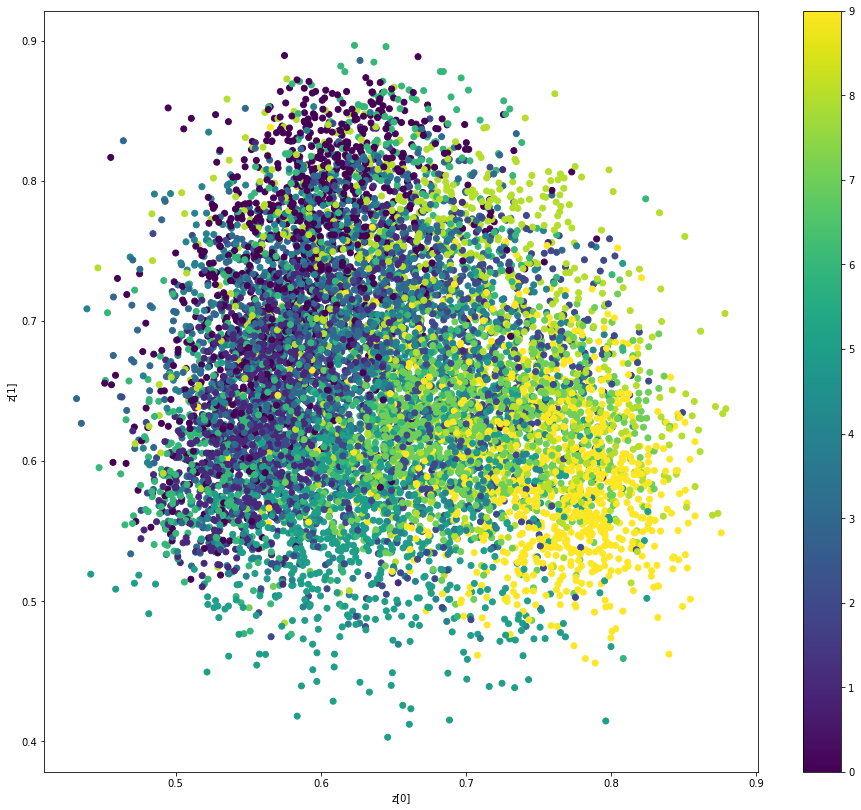

In [27]:
def bloco():
    
    # mostra um plot 2D das classes de dígitos no espaço latente
    z_mean = encoder.predict(X_test,batch_size=32)
    plt.figure(figsize=(16, 14))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=Y_test)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

bloco()

In [29]:
def bloco():

    n = 30
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))

    grid_x = np.linspace(0.0, 1.0, n)
    grid_y = np.linspace(0.0, 1.0, n)
    
    fig, ax = plt.subplots(1,1,figsize=(20,20))    

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                  j * digit_size: (j + 1) * digit_size] = digit

    start_range = digit_size // 2
    end_range = (n - 1) * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    #ax[l].set_xticks(pixel_range, sample_range_x)
    #ax[l].set_yticks(pixel_range, sample_range_y)
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_xlabel("z[0]")
    ax.set_ylabel("z[1]")
    ax.imshow(figure, cmap='gray_r')      
    
    #plt.tight_layout()
    plt.show()

bloco()

Output hidden; open in https://colab.research.google.com to view.